# FCR in Dimensions

The goal of this notebook is to analyze
the FCR index data of a single journal
based on the CSV reports
from [Dimensions](https://app.dimensions.ai).
We can get at most $500$ entries from its search system,
which suffices in our case
without an extra step of search splitting and CSV joining
(sadly, we couldn't download the full data from some journals
 due to that limit on the number of rows
 and due to the constrained ways os manually splitting the data
 in the interface).

*Note*: Be careful when downloading stuff from a single journal!
As the Dimensions' web interface uses the journal name for filtering
instead of its ISSN,
sometimes we can grab a CSV from more than one journal
because they happen to have the same name.
As an example, *Topoi* can be either a
[Brazilian journal of history](http://revistatopoi.org)
and a
[Dutch journal of philosophy](https://link.springer.com/journal/11245),
but these journals are mixed together in that interface.

There are two CSV formats available:
a spreadsheet and a bibliometric mapping.
Their first line in both formats is always
a comment with some metadata regarding the downloaded CSV,
including the date.
The second line is the table header.

In [1]:
import csv

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
%matplotlib inline

## Analyzing the FCR from the spreadsheet file

There are $2$ bibliometric indices: `RCR` and `FCR`.
The former is probably useless
for anything that isn't a health science publication
regarding the research going on in the U.S.A.,
since its calculation
[is based on the number of citations from publications funded by the
 NIH](https://support.dimensions.ai/support/solutions/articles/13000045404-what-is-the-rcr-how-is-the-rcr-score-calculated-)
(*National Institutes of Health* in the U.S.A.).
The latter is the *Field Citation Ratio*,
[which is somehow normalized by both year and Field of
 Research](https://support.dimensions.ai/support/solutions/articles/13000045409-what-is-the-fcr-how-is-it-calculated-),
and is the only one we're going to analyze here.

### Loading the data

We should be explicit about the header line
since the first line of the CSV files
is a comment:

In [4]:
for fname in ["nauplius.csv", "plant_physiology.csv"]:
    with open(fname) as f:
        cr = csv.reader(f)
        print(next(cr)[0])

About the data: Exported on Sep 21, 2018. Criteria: Source title is Nauplius.
About the data: Exported on Sep 22, 2018. Criteria: Source title is Brazilian Journal of Plant Physiology.


We're going to analyze the content from these two journals.

In [5]:
nauplius = pd.read_csv("nauplius.csv", header=1)
plantp = pd.read_csv("plant_physiology.csv", header=1)
print("Nauplius:", nauplius.shape)
print("Brazilian Journal of Plant Physiology:", plantp.shape)
nauplius.columns

Nauplius: (177, 27)
Brazilian Journal of Plant Physiology: (361, 27)


Index(['Rank', 'Publication ID', 'DOI', 'PMID', 'PMCID', 'Title',
       'Source title', 'Anthology title', 'PubYear', 'Volume', 'Issue',
       'Pagination', 'Publication Type', 'Authors', 'Authors Affiliations',
       'Times cited', 'Recent citations', 'RCR', 'FCR', 'Source Linkout',
       'Dimensions URL', 'FOR (ANZSRC) Categories', 'FOR 1', 'FOR 2', 'FOR 3',
       'FOR 4', 'FOR 5'],
      dtype='object')

We can see the number of publications by year:

PubYear,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
Brazilian Journal of Plant Physiology,24,23,24,41,46,38,32,33,32,35,32,1,,,,,
Nauplius,,,,,,,,,,19,21,22,16,18,30,33,18


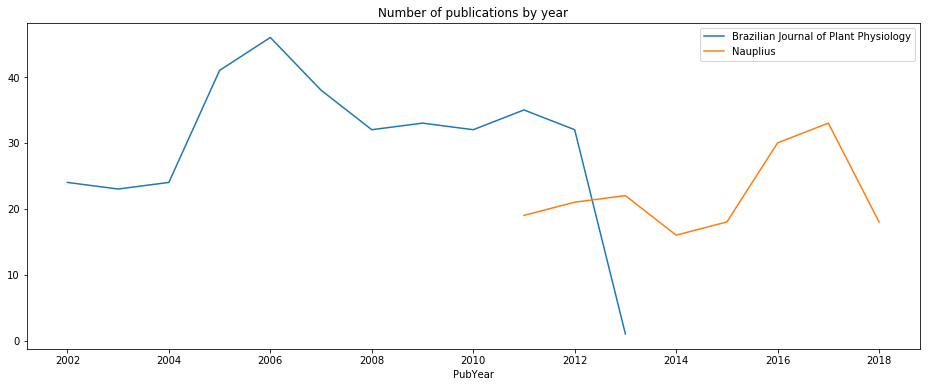

In [6]:
year_counts = pd.DataFrame([
    plantp.groupby("PubYear").size().rename("Brazilian Journal of Plant Physiology"),
    nauplius.groupby("PubYear").size().rename("Nauplius"),
], dtype=int)
year_counts.T.plot(title="Number of publications by year",
                   figsize=(16, 6))
year_counts.fillna("")

Which shows that *Nauplius* is a quite new and currently active journal,
whereas the *Brazilian Journal of Plant Physiology*
is no longer publishing anything
(actually, it had been renamed to
 *Theoretical and Experimental Plant Physiology*,
 with a new ISSN: 2197-0025).

Due to the way the FCR is calculated and normalized
(by the publication year in the document level),
its behavior is quite different
in these two distinct journal contexts.

### Proportion where the FCR is zero

From the [FCR
 explanation](https://support.dimensions.ai/support/solutions/articles/13000045409-what-is-the-fcr-how-is-it-calculated-)
page in the Dimensions support,
we know that:

> The FCR is calculated for all publications in Dimensions
> which are at least 2 years old and were published in 2000 or later.

FCR is zero when a document hadn't received any citation
or when it was published in the last $2$ years.
That's a quite common case, surely for new papers,
which deserves its own analysis.

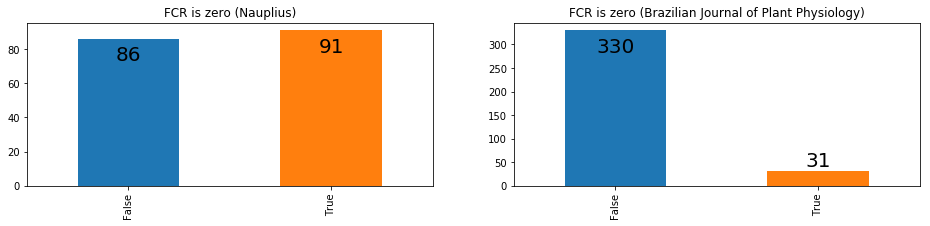

In [7]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 3))
(nauplius["FCR"] == 0).value_counts().sort_index().plot.bar(ax=ax1,
    title="FCR is zero (Nauplius)"
)
(plantp["FCR"] == 0).value_counts().sort_index().plot.bar(ax=ax2,
    title="FCR is zero (Brazilian Journal of Plant Physiology)",
)
for ax in [ax1, ax2]:
    for rect in ax.patches:
        value = rect.get_height()
        ax.annotate(value, (rect.get_x() + rect.get_width() / 2,
                            value / 1.05 if value > 50 else value * 1.05),
                    ha="center",
                    va="bottom" if value < 50 else "top",
                    fontsize=20)

For a recent journal, more than half of the entries have zero as its FCR.
The FCR mean for this journal as a whole
would be tainted if we count these entries as equal.
For a journal that is no longer publishing,
the FCR can only increase.

Most entries with zeroed FCR values are for $2017$ and $2018$,
years where all entries are zero.

fcr_is_zero,False,True
PubYear,,
2011,17,2
2012,14,7
2013,18,4
2014,11,5
2015,12,6
2016,14,16
2017,0,33
2018,0,18


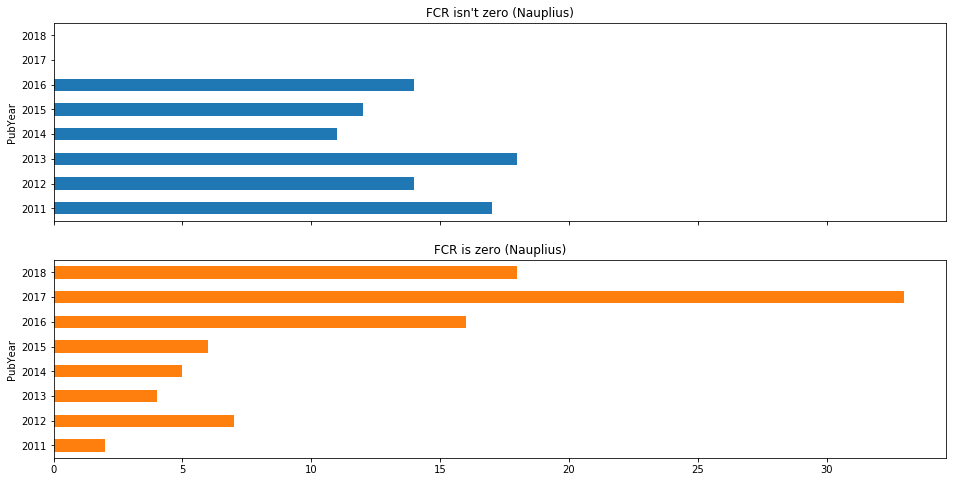

In [8]:
nauplius_counts = pd.DataFrame(
    nauplius
        .assign(fcr_is_zero=nauplius["FCR"] == 0)
        .groupby(["fcr_is_zero", "PubYear"])
        .size()
        .rename("count")
        .unstack("fcr_is_zero")
        .fillna(0),
    dtype=int,
)
nauplius_counts.plot.barh(subplots=True,
                          title=["FCR isn't zero (Nauplius)",
                                 "FCR is zero (Nauplius)"],
                          legend=False,
                          figsize=(16, 8))
nauplius_counts

As $2017$ was the publication peak for Nauplius,
averaging the raw FCR number for every year is unfair.

For the Brazilian Journal of Plant Physiology,
these are the ones from $2002$
have something different going on.

fcr_is_zero,False,True
PubYear,,
2002,11,13
2003,23,0
2004,23,1
2005,40,1
2006,44,2
2007,37,1
2008,31,1
2009,31,2
2010,30,2


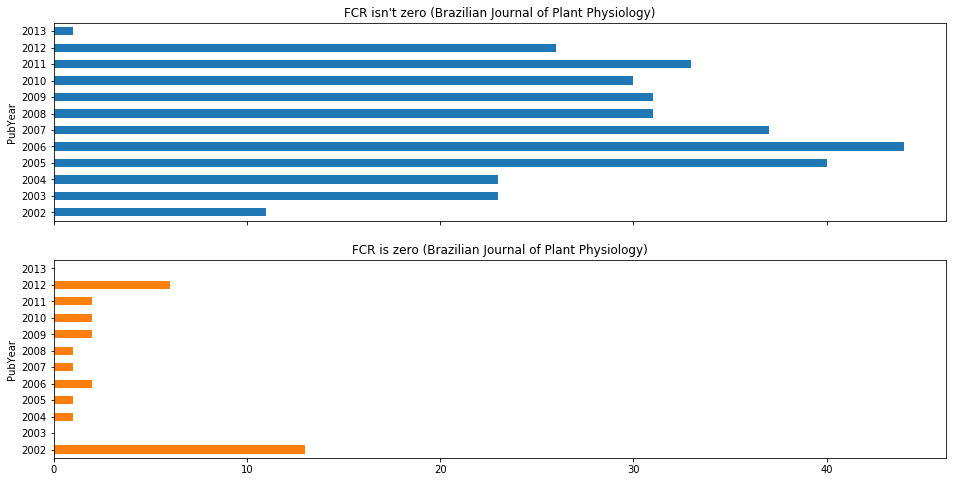

In [9]:
plantp_counts = pd.DataFrame(
    plantp
        .assign(fcr_is_zero=plantp["FCR"] == 0)
        .groupby(["fcr_is_zero", "PubYear"])
        .size()
        .rename("count")
        .unstack("fcr_is_zero")
        .fillna(0),
    dtype=int,
)
plantp_counts.plot.barh(subplots=True,
                        title=["FCR isn't zero (Brazilian Journal of Plant Physiology)",
                               "FCR is zero (Brazilian Journal of Plant Physiology)"],
                        legend=False,
                        figsize=(16, 8))
plantp_counts

The reason is that the FCR can only be calculated
if we know the *Field of Research* of every single document.
However, from the same link as before,

> Assigning FoR codes to publications in Dimensions is done automatically using machine learning emulations of the categorisation processes.

The FCR can't be negative,
but when a document lacks its category,
the FCR is zero.

In [10]:
pd.DataFrame([
    nauplius["FOR (ANZSRC) Categories"].isna().sum(),
    plantp["FOR (ANZSRC) Categories"].isna().sum(),
], index=["Nauplius", "Brazilian Journal of Plant Physiology"],
   columns=["Entries lacking a field of research category"])

,Entries lacking a field of research category
Nauplius,14
Brazilian Journal of Plant Physiology,26


As $\text{FCR} \ge 0$ and $\sum \text{FCR}_i = 0$,
all these journals have $\text{FCR} = 0$.

In [11]:
plantp[plantp["FOR (ANZSRC) Categories"].isna()]["FCR"].sum() + \
nauplius[nauplius["FOR (ANZSRC) Categories"].isna()]["FCR"].sum()

0.0

For the *Brazilian Journal of Plant Physiology*,
it's clearly biased towards $2002$
(half of the non-classified entries are from this year):

In [12]:
plantp[plantp["FOR (ANZSRC) Categories"].isna()].groupby("PubYear").size()

PubYear
2002    13
2004     1
2005     1
2006     2
2008     1
2009     2
2010     1
2011     2
2012     3
dtype: int64

For Nauplius, it's less skewed.

In [13]:
nauplius[nauplius["FOR (ANZSRC) Categories"].isna()].groupby("PubYear").size()

PubYear
2011    1
2012    2
2013    3
2015    2
2016    2
2017    1
2018    3
dtype: int64

### Data cleaning

The cleaning we're sure that must be done
in order to have meaningful entries
for further analysis regarding the FCR
is that we should only use data up to $2016$
and get rid from entries without a main field of research.

In [14]:
nauplius_valid = nauplius[nauplius["FOR (ANZSRC) Categories"].notna() &
                          (nauplius["PubYear"] <= 2016)]
plantp_valid = plantp[plantp["FOR (ANZSRC) Categories"].notna()]

In the CSV files, everything is an article,
so we shouldn't remove any other row:

In [15]:
pd.concat([nauplius["Publication Type"],
           plantp["Publication Type"]]).drop_duplicates()

0    article
Name: Publication Type, dtype: object

### Hirsch index

As the total number of citations each document received is given,
we can calculate the Hirsch index for these two journals
based on the entire data.

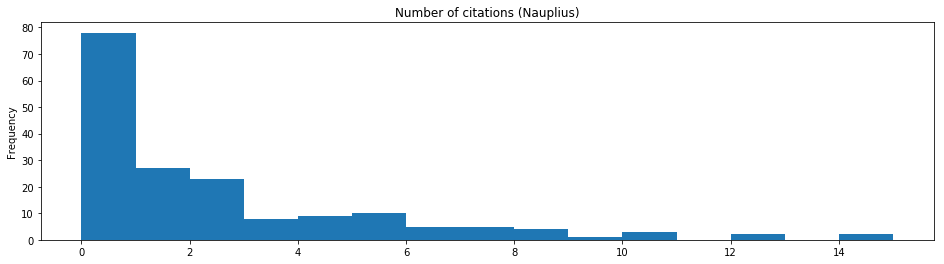

In [16]:
nauplius["Times cited"].plot.hist(
    bins=nauplius["Times cited"].max(),
    title="Number of citations (Nauplius)",
    figsize=(16, 4),
);

The Hirsch index for Nauplius is:

In [17]:
(nauplius["Times cited"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
    .reset_index()
    .values.min(axis=1)
    .max()
)

8

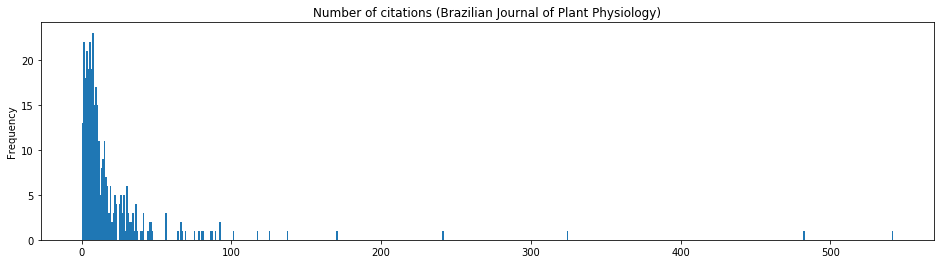

In [18]:
plantp["Times cited"].plot.hist(
    bins=plantp["Times cited"].max(),
    title="Number of citations (Brazilian Journal of Plant Physiology)",
    figsize=(16, 4),
);

The Hirsch index for the Brazilian Journal of Plant Physiology is:

In [19]:
(plantp["Times cited"]
    .value_counts()
    .sort_index(ascending=False)
    .cumsum()
    .reset_index()
    .values.min(axis=1)
    .max()
)

37

The above is based on all citations since the publication,
which is something that might lean toward older publications.

### Proportion where FCR isn't zero

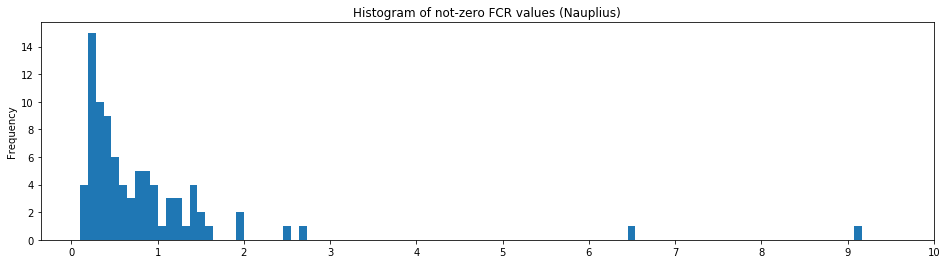

In [20]:
nauplius[nauplius["FCR"] != 0]["FCR"].plot.hist(
    bins=100,
    title="Histogram of not-zero FCR values (Nauplius)",
    figsize=(16, 4),
    xticks=range(int(nauplius["FCR"].max()) + 2),
);

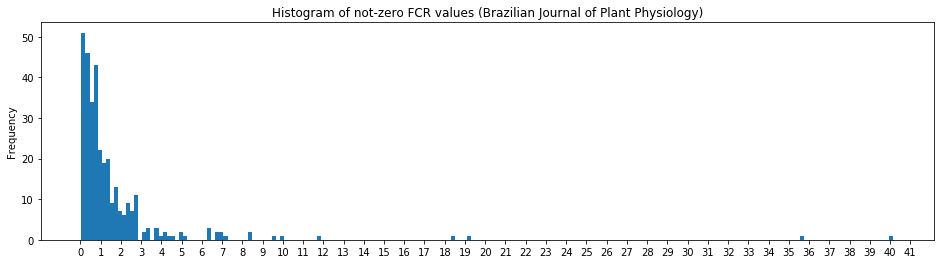

In [21]:
plantp[plantp["FCR"] != 0]["FCR"].plot.hist(
    bins=200,
    title="Histogram of not-zero FCR values "
          "(Brazilian Journal of Plant Physiology)",
    figsize=(16, 4),
    xticks=range(int(plantp["FCR"].max()) + 2),
);

All FCR values above $1$ received more citations than the average
for the year of publication and for the field of research.
That normalization makes FCR more fit than the raw number of citations
when we're looking to summary data
without knowing when each publication had been made.

### Average

Dimensions tells us the average FCR for Nauplius is $0.49$.
That means that the number of citations it received is,
in average,
about half of the average number of citations
of its field of research area.
For the Brazilian Journal of Plant Physiology,
the average FCR is $1.07$.
Each of these are called *FCR Mean* in the Dimensions' web site.

The idea of *average* might be misleading here.
As the mean value is highly influenced by extreme values,
In the same link as before,
Dimensions tells us they're using
a shifted geometric mean with logarithmic formulation
for everything regarding FCR.
From their description,
we know that:

$$
\operatorname{geometric mean of} FCR =
\exp \left[ \frac{1}{N} \sum_{i=1}^{N} \ln(FCR_i + 1) \right] - 1
$$

And the same idea applies for the average number of citations
(by year and field of research)
that is used to calculate the FCR.
We can easily implement the above formula using Numpy:

In [22]:
def sgm_average(series):
    return np.exp(np.log(series.values + 1).mean()) - 1

## Yearly mean and shifted geometric mean/average

Here we'll calculate a "cumulative" mean and shifted geometric average,
which means the mean or shifted geometric average of
*all publications up to the year in analysis*,
in contrast with the year-by-year statistics.

In [23]:
def get_yearly_stats(clean_dataset):
    cum_groups = [
        (year, clean_dataset[clean_dataset["PubYear"] <= year]["FCR"])
        for year in clean_dataset["PubYear"].unique()
    ]
    return pd.DataFrame(
        [(year, sgm_average(group), group.mean())
         for year, group in cum_groups],
        columns=["year", "cum_shifted_geom_average", "cum_mean"]
    ).set_index("year").assign(
        shifted_geom_average=clean_dataset.groupby("PubYear")["FCR"].apply(sgm_average),
        mean=clean_dataset.groupby("PubYear")["FCR"].mean(),
    )[["cum_mean", "mean", "cum_shifted_geom_average", "shifted_geom_average"]]

In [24]:
def plot_yearly_stats(stats, journal_name):
    stats.plot(
        figsize=(14, 6),
        title="Mean and shifted geometric average of FCR, "
              f"cumulative up to an year and isolated ({journal_name})",
    )
    for line, marker in zip(plt.gca().get_lines(), "xoDs"):
        line.set_marker(marker)
    plt.gca().legend()

,cum_mean,mean,cum_shifted_geom_average,shifted_geom_average
year,,,,
2016,0.647931,0.863571,0.484481,0.440366
2015,0.579318,0.562500,0.498798,0.473841
2014,0.583056,0.373750,0.504402,0.325564
2013,0.642857,0.826316,0.559795,0.721414
2012,0.548649,0.551579,0.482791,0.475847
2011,0.545556,0.545556,0.490157,0.490157


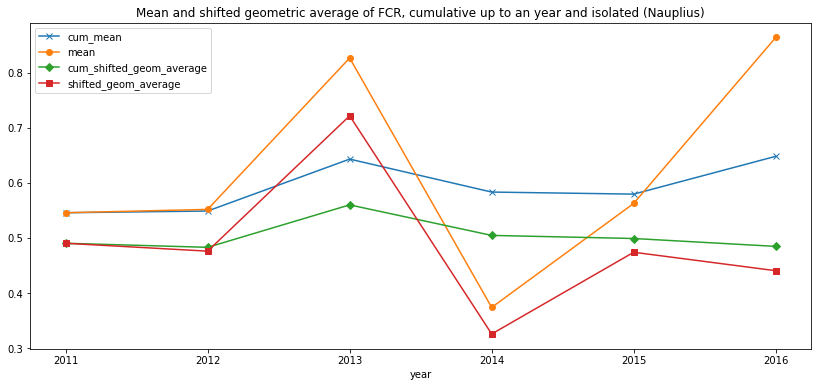

In [25]:
nauplius_fcr_year = get_yearly_stats(nauplius_valid)
plot_yearly_stats(nauplius_fcr_year, "Nauplius")
nauplius_fcr_year

,cum_mean,mean,cum_shifted_geom_average,shifted_geom_average
year,,,,
2013,1.663134,1.480000,1.072867,1.480000
2012,1.663683,0.821034,1.071754,0.718440
2011,1.743803,0.728182,1.108916,0.658116
2010,1.867022,1.048387,1.171355,0.923672
2009,1.972324,0.691613,1.205448,0.626536
2008,2.161381,1.404194,1.306837,1.111041
2007,2.292514,2.034211,1.342545,1.533903
2006,2.362128,2.202273,1.293493,1.333378
2005,2.434639,4.189500,1.275626,1.934488


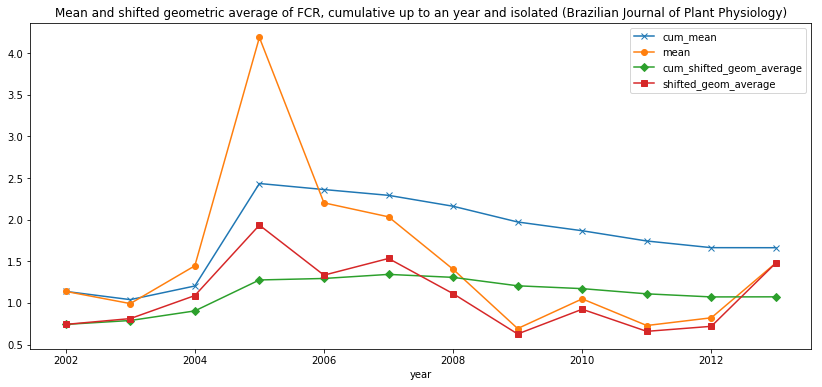

In [26]:
plantp_fcr_year = get_yearly_stats(plantp_valid)
plot_yearly_stats(plantp_fcr_year, "Brazilian Journal of Plant Physiology")
plantp_fcr_year

### Let's talk about the FCR...

These values should be re-calculated by Dimensions
to include the citations from new publications.
We are just seeing a snapshot of this index.

As a side effect of the normalization,
an article that is no longer cited will get a lower FCR
for each other article
from the same year and field of research that gets a citation.

Probably the most strange part of FCR
is the "field of research" itself,
which is found from some unknown "machine learning" algorithm and data.
Do the fields make sense, at least?

In [27]:
# Nauplius
nauplius.groupby("FOR (ANZSRC) Categories").size().sort_values()

FOR (ANZSRC) Categories
0604 Genetics; 0602 Ecology; 0502 Environmental Science and Management                                         1
1701 Psychology                                                                                                1
0502 Environmental Science and Management; 0403 Geology; 0602 Ecology                                          1
1117 Public Health and Health Services                                                                         1
0502 Environmental Science and Management; 0602 Ecology; 0604 Genetics                                         1
0502 Environmental Science and Management; 0604 Genetics                                                       1
0502 Environmental Science and Management; 0907 Environmental Engineering; 0602 Ecology; 0405 Oceanography     1
1108 Medical Microbiology                                                                                      1
1103 Clinical Sciences                                                  

In [28]:
# Brazilian Journal of Plant Physiology
plantp.groupby("FOR (ANZSRC) Categories").size().sort_values()

FOR (ANZSRC) Categories
0102 Applied Mathematics                                                                                     1
0912 Materials Engineering                                                                                   1
0904 Chemical Engineering                                                                                    1
0699 Other Biological Sciences; 0607 Plant Biology                                                           1
0607 Plant Biology; 0699 Other Biological Sciences; 0602 Ecology                                             1
0607 Plant Biology; 0605 Microbiology                                                                        1
0607 Plant Biology; 0602 Ecology; 0705 Forestry Sciences                                                     1
0607 Plant Biology; 0602 Ecology; 0699 Other Biological Sciences; 0705 Forestry Sciences                     1
0607 Plant Biology; 0601 Biochemistry and Cell Biology; 0604 Genetics; 0703 Crop and Pas

Multidisciplinary entries and misclassification
regarding publications from this and other journals
might be biasing the whole.
The trustfulness and meaningfulness of the normalization procedure
is rooted on the Dimensions' machine learning system.

The citation count for a document as used in the FCR calculation
doesn't take into account *which* other document had cited it.
Though the normalization helps
on comparing publications from different years,
the magnitude of this index might be influenced
by stuff like self-citations
and scattered never-cited \[perhaps auto-generated\] publications.

There's one important difference
between the Hirsch index and the FCR average:
not-cited publications are meaningless for the Hirsch index,
yet they push down the FCR average,
and faster than the common mean calculation
because it's using a geometric mean instead.
The geometric mean is less influenced
by extreme values near to the maximum,
but it's MORE influenced
by extreme values near to the minimum.
A single zero would weight hard on a journal
with lots of highly cited documents.
As a synthetic example:

shifted_geom_average       mean
fifteen_count zero_count                                 
10            0                      15.000000  15.000000
              1                      11.435250  13.636364
              2                       9.079368  12.500000
              3                       7.438129  11.538462
              4                       6.245789  10.714286
              5                       5.349604  10.000000
              6                       4.656854   9.375000
              7                       4.108647   8.823529
              8                       3.666116   8.333333
              9                       3.302762   7.894737
              10                      3.000000   7.500000

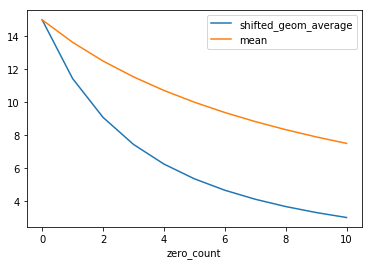

In [29]:
synth_data = pd.DataFrame([range(11)], index=["zero_count"]).T
synth_data["fifteen_count"] = 10
synth_data["shifted_geom_average"] = [sgm_average(pd.Series([0] * a + [15] * b))
                                      for a, b in synth_data.values.tolist()]
synth_data["mean"] = synth_data["fifteen_count"] * 15 \
                   / (synth_data["fifteen_count"] + synth_data["zero_count"])
synth_data.set_index(["fifteen_count", "zero_count"], inplace=True)
synth_data.reset_index(0, drop=True).plot()
synth_data

This geometric mean of zero and $15$ is $3$.
With $3$ zeros, even $10$ entries having $15$
wouldn't be enough to get $7.5$ as the average result.

This effectively means that the FCR average favors
journals with a small number of uniformly cited publications,
heavily pushing down a journal with even a single publication
with zero citations.

Due to that *pushing down* behavior
of this alternative averaging calculation,
FCR should be taken with a grain of salt
when used to evaluate journals with recent publications.

## Bibliometric mapping

Another file that can be downloaded from Dimensions
is a bibliometric mapping CSV.

### Loading the data

If follows a structure similar to the spreadsheet CSV file,
like the metadata information in the first line.

In [30]:
for fname in ["nauplius_bibmap.csv", "plant_physiology_bibmap.csv"]:
    with open(fname) as f:
        cr = csv.reader(f)
        print(next(cr)[0])

About the data: Exported on Sep 21, 2018. Criteria: Source title is Nauplius.
About the data: Exported on Sep 22, 2018. Criteria: Source title is Brazilian Journal of Plant Physiology.


But have fewer columns:

In [31]:
nauplius_bibmap = pd.read_csv("nauplius_bibmap.csv", header=1)
plantp_bibmap = pd.read_csv("plant_physiology_bibmap.csv", header=1)
print("Nauplius:", nauplius_bibmap.shape)
print("Brazilian Journal of Plant Physiology:", plantp_bibmap.shape)
plantp_bibmap.columns

Nauplius: (177, 14)
Brazilian Journal of Plant Physiology: (361, 14)


Index(['Publication ID', 'DOI', 'Title', 'Source title/Anthology title',
       'PubYear', 'Volume', 'Issue', 'Pagination', 'Authors',
       'Authors Affiliations - Name of Research organization',
       'Authors Affiliations - Country of Research organization',
       'Dimensions URL', 'Times cited', 'Publication IDs of cited references'],
      dtype='object')

Besides having less columns, the differences are:

- *Authors Affiliations* had been splitted into two fields;
- There's an extra *Publication IDs of cited references* field.

We don't have a field like *Publication IDs citing this entry*,
just the other way around.
That is,
from the directed graph of citations,
these bibliometric mapping files have a partition of the graph
including the nodes/articles from a journal and the outcoming edges,
but not the incoming edges.
It has the number of incoming edges in the *Times cited* field,
but not the citations themselves.

The citations in a document
are joined by *a semi-colon and a blank whitespace*:

In [32]:
nauplius_bibmap["Publication IDs of cited references"].iloc[0].split("; ")

['pub.1029197063',
 'pub.1002374214',
 'pub.1018747876',
 'pub.1051616960',
 'pub.1017805771',
 'pub.1014161638',
 'pub.1047379736',
 'pub.1029350483',
 'pub.1040183585',
 'pub.1084353864',
 'pub.1057031403',
 'pub.1000284258',
 'pub.1052431052',
 'pub.1046335329',
 'pub.1010113839',
 'pub.1090336053',
 'pub.1048696478',
 'pub.1005549826',
 'pub.1020510950',
 'pub.1035956564',
 'pub.1032912886',
 'pub.1049807368',
 'pub.1015284561',
 'pub.1093107594',
 'pub.1084353730']

From this, we can see an histogram of the overall number of citations
of the papers:

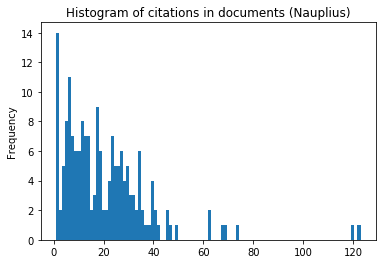

In [33]:
nauplius_out_cite = (nauplius_bibmap
    ["Publication IDs of cited references"]
    .fillna("") # Unknown / empty citation list
    .str.split("; ")
    .apply(set) # Remove duplicated IDs, if any
)
nauplius_out_cite.apply(len).plot.hist(
    bins=100,
    title="Histogram of citations in documents (Nauplius)",
);

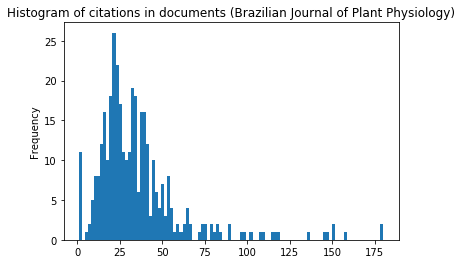

In [34]:
plantp_out_cite = (plantp_bibmap
    ["Publication IDs of cited references"]
    .fillna("") # Unknown / empty citation list
    .str.split("; ")
    .apply(set) # Remove duplicated IDs, if any
)
plantp_out_cite.apply(len).plot.hist(
    bins=100,
    title="Histogram of citations in documents "
          "(Brazilian Journal of Plant Physiology)",
);

As we have all the publication IDs,
we can also see how many journal self-citation there are
in these publications.

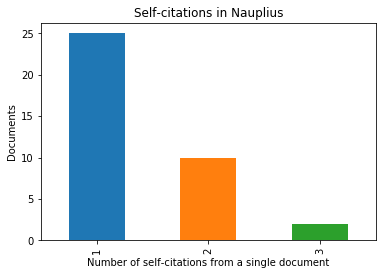

In [35]:
nauplius_ids = nauplius_bibmap["Publication ID"].values
nauplius_self_cites = \
    nauplius_out_cite.apply(lambda cites: sum(cite in nauplius_ids
                                              for cite in cites))
nauplius_self_cites[nauplius_self_cites > 0].value_counts().plot.bar()
plt.gca().set(
    title="Self-citations in Nauplius",
    xlabel="Number of self-citations from a single document",
    ylabel="Documents",
);

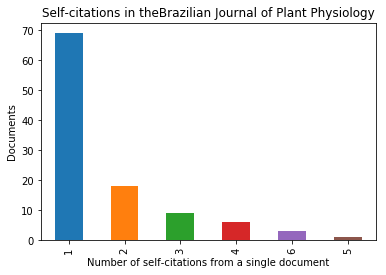

In [36]:
plantp_ids = plantp_bibmap["Publication ID"].values
plantp_self_cites = \
    plantp_out_cite.apply(lambda cites: sum(cite in plantp_ids
                                            for cite in cites))
plantp_self_cites[plantp_self_cites > 0].value_counts().plot.bar()
plt.gca().set(
    title="Self-citations in the"
          "Brazilian Journal of Plant Physiology",
    xlabel="Number of self-citations from a single document",
    ylabel="Documents",
);